In [1]:
import pymesh
import numpy as np
import transforms3d
from scipy.spatial.distance import cdist,pdist
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
import matplotlib


In [2]:
mesh_pts = pymesh.load_mesh("bunny/bun_zipper_res4_sds.ply")
mesh0 = pymesh.load_mesh("bunny/bun_zipper_res4.ply")
SAMPLE_PTS = 453
full_points = mesh0.vertices
t = np.random.rand(3)*0.1 - 0.05
angles = np.random.rand(3)*30 - 15
angles *= np.pi/180.0
#angles *= 0 
M = transforms3d.euler.euler2mat(angles[0],angles[1],angles[2])
true_q = transforms3d.quaternions.mat2quat(M)
indices = np.random.randint(0,full_points.shape[0],SAMPLE_PTS)
samples= full_points#[indices]
source = (samples-samples.mean(0)) @ M  + samples.mean(0) + t

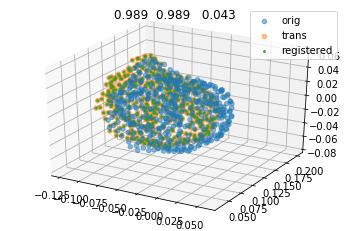

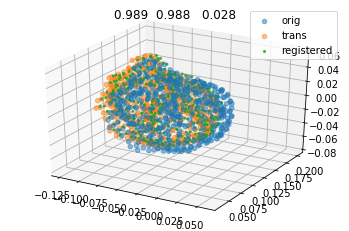

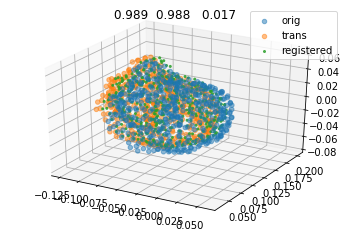

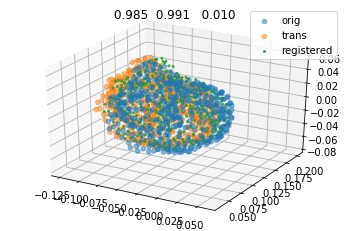

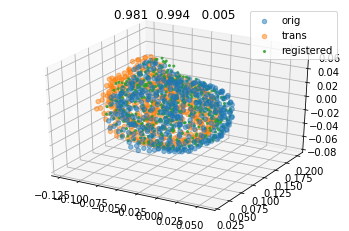

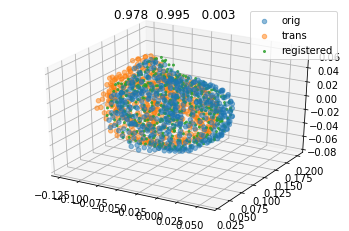

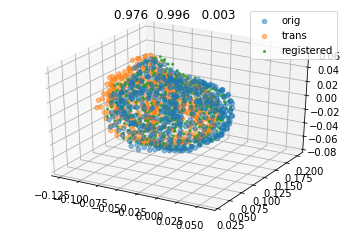

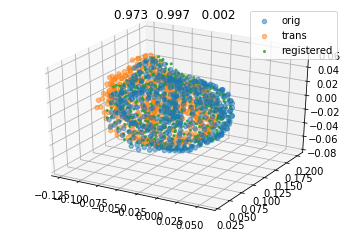

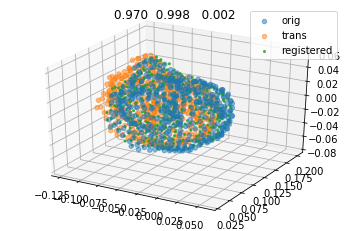

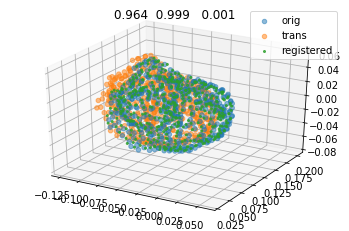

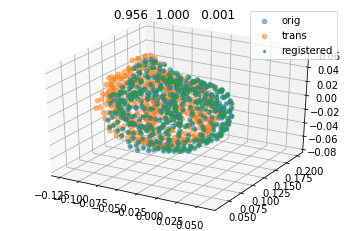

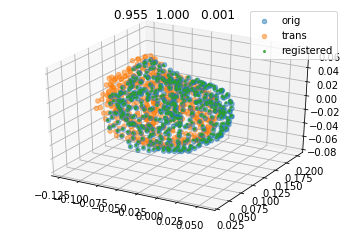

In [3]:
icp_t = np.zeros(3)
R = np.identity(3)
source2 = np.copy(source)
prev_err = 100000000
indices2 = np.random.randint(0,full_points.shape[0],SAMPLE_PTS)
samples_for_icp = np.copy(samples) #full_points[indices2]
flag = True
icp_q = np.array([1,0,0,0])
for icp_iter in range(50):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(samples[:,0],samples[:,1],samples[:,2],label='orig',alpha=0.5)

    ax.scatter(source[:,0],source[:,1],source[:,2],label='trans',alpha=0.5)    
    result = (source - icp_t) 
    result = (result - result.mean(0)) @ R.T + result.mean(0)
    ax.scatter(result[:,0],result[:,1],result[:,2],label='registered',alpha=0.8,s=4)
    plt.title('{:.3f}  {:.3f}   {:.3f}'.format(icp_q.dot(transforms3d.quaternions.qconjugate(true_q)),icp_q.dot(true_q),np.linalg.norm(icp_t-t)) )
    plt.legend()
    plt.show()
    
    dist = cdist(source2,samples_for_icp)
    sample_idx = np.argmin(dist,1)
    matched_pts = samples_for_icp[sample_idx]
    it =  source2.mean(0) - matched_pts.mean(0)
    if flag:
        idx2 = np.argmin(dist,0)
        matched2 = source2[idx2]
        it += matched2.mean(0) - samples_for_icp.mean(0)

    H = (source2-source2.mean(0)).T @ (matched_pts-matched_pts.mean(0))
    if flag:
        H2 = (matched2-matched2.mean(0)).T @ (samples_for_icp-samples_for_icp.mean(0))
        H2 *= source2.shape[0]/samples_for_icp.shape[0]
        H = H + H2
    u,s,vt = np.linalg.svd(H)
    rotmat = vt.T @ np.diag([1,1,np.linalg.det(vt.T @ u.T)]) @ u.T
    rotmat = rotmat.T
    #print(rotmat,'\n',M)
    #print(it,'\n',t)

    source2 = (source2 - source2.mean(0)) @ rotmat + source2.mean(0) - it 
    err = np.linalg.norm(source2-matched_pts,axis=1)
    err = err.mean()
    #print(err)
    #print(np.diag(cdist(source2,matched_pts)).mean(),len(matched_pts))
    if np.linalg.norm(err-prev_err) < 1e-6:
        break
    prev_err = err
    icp_t += it
    R = R @ rotmat.T
    #print(it)
    #print(rotmat)

    icp_q = transforms3d.quaternions.mat2quat(R)
    icp_t = icp_t



In [4]:
t,icp_t

(array([-0.03273832,  0.02572913, -0.01184819]),
 array([-0.03230397,  0.02601768, -0.01214261]))

<IPython.core.display.Javascript object>


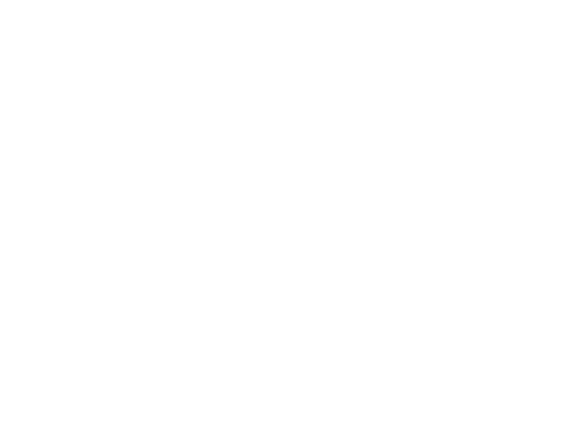

In [5]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples[:,0],samples[:,1],samples[:,2],label='orig',alpha=0.5)

ax.scatter(source[:,0],source[:,1],source[:,2],label='trans',alpha=0.5)    
result = (source - icp_t) 
result = (result - result.mean(0)) @ R.T + result.mean(0)
ax.scatter(result[:,0],result[:,1],result[:,2],label='registered',alpha=0.8,s=4)
plt.title('{:.3f}  {:.3f}   {:.3f}'.format(icp_q.dot(transforms3d.quaternions.qconjugate(true_q)),icp_q.dot(true_q),np.linalg.norm(icp_t-t)) )
plt.legend()
plt.show()
    

In [6]:
res = source
res = (res - res.mean(0)) @ M.T + res.mean(0) - t
res

array([[-0.0312216 ,  0.126304  ,  0.00514924],
       [-0.0446774 ,  0.131204  ,  0.00570479],
       [-0.0683011 ,  0.144828  ,  0.0413688 ],
       ...,
       [-0.00654912,  0.0350372 ,  0.0453959 ],
       [-0.0307826 ,  0.0347596 ,  0.0432959 ],
       [-0.0180834 ,  0.0348142 ,  0.0458772 ]])

In [7]:
source2

array([[-0.03078725,  0.12659255,  0.00485482],
       [-0.04424305,  0.13149255,  0.00541037],
       [-0.06786675,  0.14511655,  0.04107438],
       ...,
       [-0.00611477,  0.03532575,  0.04510148],
       [-0.03034825,  0.03504815,  0.04300148],
       [-0.01764905,  0.03510275,  0.04558278]])

In [8]:
np.diag(cdist(res,matched_pts)).mean()

1.5913557705189984e-17

In [9]:
np.diag(cdist(matched_pts,samples)).mean()

0.0

In [10]:
%matplotlib notebook
# 'GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg', 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template'

<IPython.core.display.Javascript object>


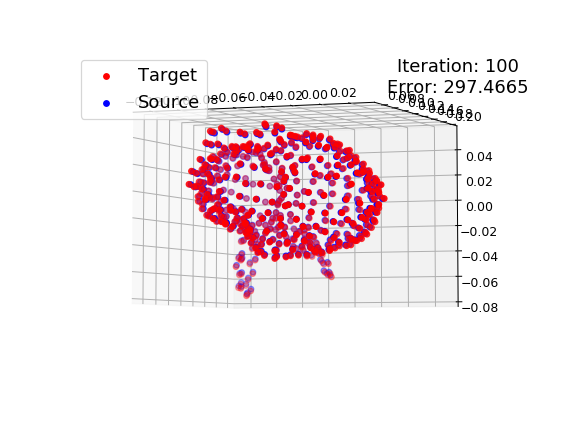

In [11]:
from functools import partial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pycpd import rigid_registration
import numpy as np
import time

def visualize(iteration, error, X, Y, ax):
    plt.cla()
    ax.scatter(X[:,0],  X[:,1], X[:,2], color='red', label='Target')
    ax.scatter(Y[:,0],  Y[:,1], Y[:,2], color='blue', label='Source')
    ax.text2D(0.87, 0.92, 'Iteration: {:d}\nError: {:06.4f}'.format(iteration, error), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize='x-large')
    ax.legend(loc='upper left', fontsize='x-large')
    plt.draw()
    plt.pause(0.001)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
callback = partial(visualize, ax=ax)

reg = rigid_registration(**{ 'X': source, 'Y': samples_for_icp })
reg.register(callback)
plt.show()



In [12]:
reg = rigid_registration(**{ 'X': source, 'Y': samples_for_icp, 'max_iterations':500,'tolerance':1e-8 })


In [13]:
 TY, (s_reg, R_reg, t_reg) = reg.register()

In [14]:
R_reg

array([[ 0.9789206 , -0.0394667 , -0.20039173],
       [-0.0049885 ,  0.97623945, -0.21663716],
       [ 0.20418027,  0.21307023,  0.95546402]])

In [26]:
s_reg

1.0000000000000002

In [16]:
TY

array([[-0.06467871,  0.15075445, -0.01274476],
       [-0.07776188,  0.15618745, -0.01057904],
       [-0.09367369,  0.17801903,  0.02527917],
       ...,
       [-0.03185345,  0.06925782,  0.0405371 ],
       [-0.0560035 ,  0.06949579,  0.04344695],
       [-0.04304521,  0.06959789,  0.04335665]])

In [25]:
t_reg,t,np.linalg.norm(t_reg-t)/0.05

(array([-0.03453655,  0.02512214,  0.00344092]),
 array([-0.03273832,  0.02572913, -0.01184819]),
 0.30812908447000087)

In [18]:
M

array([[ 0.9789206 , -0.0394667 , -0.20039173],
       [-0.0049885 ,  0.97623945, -0.21663716],
       [ 0.20418027,  0.21307023,  0.95546402]])

In [19]:
samples= full_points
samples_mean = samples.mean(0)
centered_points = samples - samples_mean
source = centered_points @ M + samples_mean+ t

In [20]:
np.linalg.norm( (source-source.mean(0))@M.T +source.mean(0) - t - samples,axis=1).sum()

7.208841640451063e-15

In [21]:
samples_mean

array([-0.02538796,  0.09232343,  0.00844166])

In [22]:
samples_mean.shape

(3,)